# Set up environment

In [381]:
import os
os.chdir('/Users/burkelawlor/Repos/fmri-animation')

import numpy as np
import pandas as pd
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nilearn import image, plotting, masking
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker

# Load and mask the data

In [2]:
# Load the 4D fMRI data
sample = 'sub-01_ses-V1_task-S2_run-02_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold'
fmri_file = os.path.join('data', sample, f'{sample}.nii.gz')
fmri_img = nib.load(fmri_file)
print(fmri_img.shape)
print(fmri_img.affine)

# Load network parcellations
labels_file = 'data/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii'
labels_img = nib.load(labels_file)
labels_img = image.resample_img(labels_img, target_affine=labels_img.affine, target_shape=fmri_img.shape[:3]) # Resample the shape but not the affine to preserve the network labels
print(labels_img.shape)

(97, 115, 97, 888)
[[   2.     0.     0.   -96.5]
 [   0.     2.     0.  -132.5]
 [   0.     0.     2.   -78.5]
 [   0.     0.     0.     1. ]]
(97, 115, 97)


In [3]:
# Load 
labels_df = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['network_label', 'network_full', 'x', 'y', 'z', 't'])
labels = list(labels_df['network_full'])
labels.insert(0, 'Background')

In [4]:
masker = NiftiLabelsMasker(
    labels_img,
    labels = labels,
    smoothing_fwhm=6,
    standardize='zscore_sample',
    standardize_confounds="zscore_sample",
    memory='nilearn_cache',
)

masker.fit(fmri_img)
report = masker.generate_report()
report

In [5]:
# Apply the masker to the data
masked_fdata = masker.transform(fmri_img)
masked_img = masker.inverse_transform(masked_fdata)

In [368]:
out_file = os.path.join('data', sample, f'parcellated.nii.gz')
nib.save(masked_img, out_file)

# Dynamic correlation matrix

Caluclate the correlation matrix for each widow in a sliding window

In [102]:
from nilearn.connectome import ConnectivityMeasure

def calculate_dynamic_correlation_matrix(masked_fdata, window_size=44, step_size=2, save=False):
    # Set number of windows
    n_windows = (masked_fdata.shape[0] - window_size) // step_size + 1
    print(f'Number of windows: {n_windows}')

    # Calculate connectivity matrix for each time window
    connectivity_matrices = np.zeros((n_windows,100,100))
    for i in range(n_windows):
        window_fdata = masked_fdata[i*step_size:i*step_size+window_size, :]
        connectivity_measure = ConnectivityMeasure(
            kind="correlation",
            standardize="zscore_sample",
        )
        connectivity_matrix = connectivity_measure.fit_transform([window_fdata])[0]
        np.fill_diagonal(connectivity_matrix, 0)
        connectivity_matrices[i] = connectivity_matrix
    
    if save:
        out_file = os.path.join('data', sample, f'dynamic_correlation_matrix_window{window_size}s_step{step_size}s.npy')
        np.save(out_file, connectivity_matrices)
    
    return connectivity_matrices

In [394]:
masked_fdata.shape

(888, 100)

In [106]:
connectivity_matrices = calculate_dynamic_correlation_matrix(masked_fdata, window_size=44, step_size=2)
connectivity_matrices.shape

Number of windows: 423


(423, 100, 100)

Plot correlation matrices in heatmap and save to static images

In [182]:
def connectivity_matrices_to_images(connectivity_matrices, labels, out_dir='images_static/corr_matrices', dpi=100):
    for i in range(connectivity_matrices.shape[0]):
        connectivity_matrix = connectivity_matrices[i]
        plotting.plot_matrix(
            connectivity_matrix,
            figure=(12,12),
            labels=labels[1:], # The labels we have start with the background (0), hence we skip the first label
            vmax=0.8,
            vmin=-0.8,
            title="Correlation matrix of Schaefer 100 parcellation",
            reorder=False,
        )
        plt.savefig(os.path.join(out_dir, f'corr_matrix_{i}.png', dpi=dpi))

In [ ]:
connectivity_matrices_to_images(connectivity_matrices, labels)

Combine static images into gif

In [207]:
import re
from glob import glob
import imageio.v3 as iio

def extract_integer(filename, pattern):
    match = re.search(pattern, filename)
    return int(match.group(1)) if match else float('inf')

def sort_files(file_list, pattern):
    return sorted(file_list, key=lambda x: extract_integer(x, pattern))

def load_image_files(file_pattern):
    image_files = glob(file_pattern)
    image_files = sort_files(image_files, file_pattern.replace(r'*', r'(\d+)'))
    return image_files

def make_gif_from_images(static_images, out_path):
    frames = np.stack([iio.imread(f) for f in static_images], axis=0)
    iio.imwrite(out_path, frames, format='gif', fps=300)

In [ ]:
image_file_pattern = 'images_static/corr_matrices/corr_matrix_*.png'
static_images = load_image_files(image_file_pattern)
make_gif_from_images(static_images, 'gifs/corr_matrices_test.gif')

# Global function connectivity

In [ ]:
def calculate_per_parcel_gfc(connectivity_matrix):
    '''Calculate the global functional connectivity for each parcel in the Schaefer 100 parcellation
        aka the average correlation of each parcel to all other parcels'''
    n_parcels, _ = connectivity_matrix.shape
    per_parcel_connectivity = np.sum(connectivity_matrix, axis=0) / (n_parcels-1) # Divide by n_parcels-1 to exclude the diagonal
    return per_parcel_connectivity

In [261]:
# apply the function to all connectivity matrices
per_parcel_connectivities = np.array([calculate_per_parcel_gfc(cm) for cm in connectivity_matrices])
print(per_parcel_connectivities.shape)


(423, 100)


Global functional connectivity of PCC

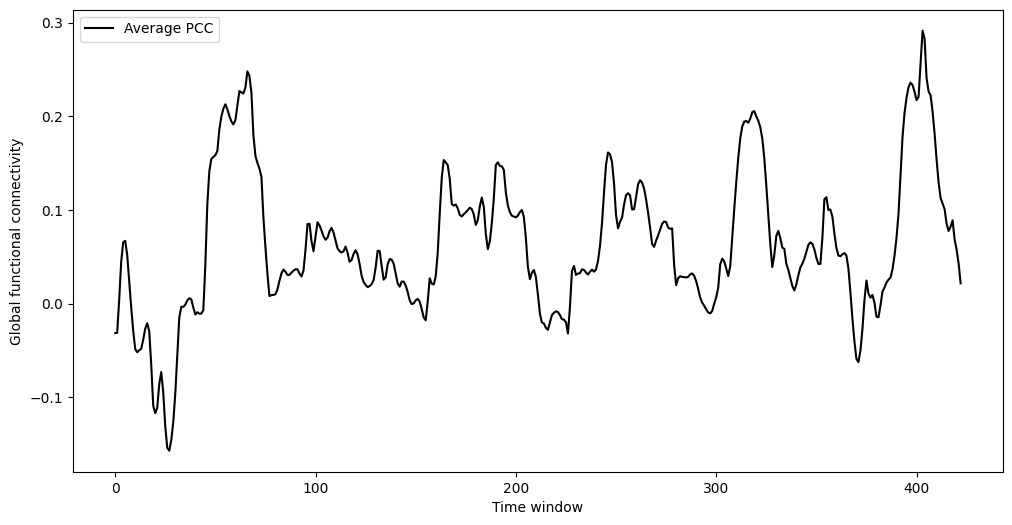

In [345]:
def plot_single_parcel_gfc(parcel_connectivity, label, color=None):
    plt.plot(parcel_connectivity, label=label, c=color)
    plt.xlabel('Time window')
    plt.ylabel('Global functional connectivity')
    plt.legend()

def plot_multi_parcel_gfc(parcel_connectivities, labels):
    n_parcels = parcel_connectivities.shape[1]
    for i in range(n_parcels):
        plt.plot(parcel_connectivities[:,i], label=labels[i])
    plt.xlabel('Time window')
    plt.ylabel('Global functional connectivity')
    plt.legend()

# Get the parcels of interest
parcels_of_interest = labels_df[labels_df.network_full.str.contains('Default_PCC')].network_full.to_numpy()
parcel_indices = [labels[1:].index(x) for x in parcels_of_interest]
parcel_connectivities = per_parcel_connectivities[:, parcel_indices]

# Calculate mean and insert it as first element
mean_parcel_connectiviy = parcel_connectivities.mean(axis=1)


plt.figure(figsize=(12,6))
# plot_multi_parcel_gfc(parcel_connectivities, parcels_of_interest)
plot_single_parcel_gfc(mean_parcel_connectiviy, 'Average PCC', color='black')
plt.show()

# Calculating mean signal intensity for networks

Trying with just one network

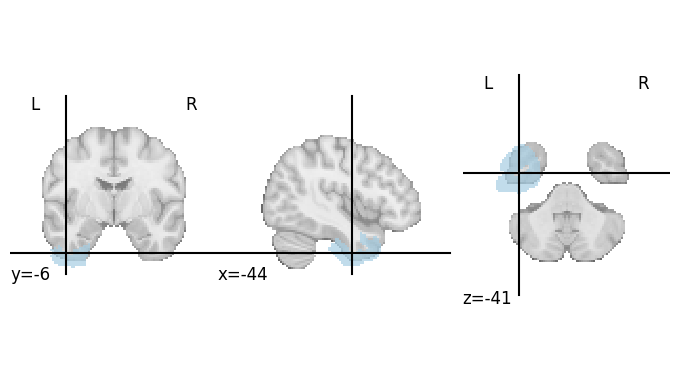

[-2.80185300e+00 -4.49823455e+00 -5.66430280e+00 -5.84354112e+00
 -5.45752642e+00 -4.73408368e+00 -3.45283976e+00 -1.77476325e+00
 -2.91520425e-01  1.02384021e+00  2.40733250e+00  3.40244886e+00
  3.88338259e+00  3.97513802e+00  3.65816113e+00  3.42705194e+00
  3.49882864e+00  3.50290882e+00  3.17323774e+00  2.32544272e+00
  1.06419262e+00 -2.61389473e-01 -1.27691270e+00 -1.88235496e+00
 -2.26360684e+00 -2.27070715e+00 -1.82060816e+00 -1.27994367e+00
 -9.78133495e-01 -8.08420196e-01 -8.48667624e-01 -1.28966526e+00
 -1.77604431e+00 -1.88350619e+00 -1.37281188e+00 -5.15337407e-01
  1.00509739e-01  3.51615163e-01  5.56325471e-01  1.09456489e+00
  1.92154453e+00  2.64765412e+00  3.36957423e+00  4.20982139e+00
  4.34910623e+00  3.33960370e+00  2.27137061e+00  2.10372290e+00
  2.54910058e+00  2.62002002e+00  1.51455672e+00 -2.03735987e-02
 -8.01732364e-01 -9.28533912e-01 -9.25498410e-01 -1.05239660e+00
 -1.54844297e+00 -2.81574080e+00 -4.75055801e+00 -6.60133265e+00
 -7.65866861e+00 -8.06538

In [10]:
network = 80

# Create a mask for the network
mask = (labels_img.get_fdata() == network).astype(float)
mask_img = nib.Nifti1Image(mask, fmri_img.affine) # Create mask image, now with the fMRI affine
plotting.plot_roi(mask_img, cmap='Paired')
plotting.show()

# Apply the mask to the fMRI data
fmri_network_img = masking.apply_mask(fmri_img, mask_img)

# Calculate the mean intensity of the network for each timepoint
mean_intensity_timeseries = fmri_network_img.mean(axis=1)
print(mean_intensity_timeseries)

Looping over all networks

In [10]:
result_list = []

with alive_bar(100, force_tty=True, length=15) as bar:
    for network in range(1, 101):
        # Create a mask for the network
        mask = (labels_img.get_fdata() == network).astype(float)
        mask_img = nib.Nifti1Image(mask, fmri_img.affine)

        # Apply the mask to the fMRI data
        fmri_network_img = masking.apply_mask(fmri_img, mask_img)

        # Calculate the mean intensity of the network for each timepoint
        mean_intensity_timeseries = fmri_network_img.mean(axis=1)

        # Append the result to the result list
        result_list.append({'network_label': network, 'mean_intensity_timeseries': mean_intensity_timeseries})
        bar()

mean_intensity_timeseries_df = pd.DataFrame(result_list)
mean_intensity_timeseries_df.to_csv(f'data/{sample}/Schaefer2018_100Parcels_7Networks_order_mean_intensity_timeseries.csv', index=False)

|███████████████| 100/100 [100%] in 1:50:27.4 (0.01/s)                          


**Plot the mean intensities of each network over time**

Split them up by genreal network to make it more managable to view.

In [82]:
# Load the mean intensity timeseries for a sample
def load_mean_intensity_timeseries(sample):
    network_labels = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['network_label', 'network_full', 'x', 'y', 'z', 't'])

    mean_intensities = pd.read_csv(f'data/{sample}/Schaefer2018_100Parcels_7Networks_order_mean_intensity_timeseries.csv')
    mean_intensities.mean_intensity_timeseries = mean_intensities.mean_intensity_timeseries.apply(lambda x: x.strip('[]').split())
    mean_intensities = pd.merge(network_labels[['network_label','network_full']], mean_intensities, on='network_label')

    labels = mean_intensities.network_full.str.split('_')
    mean_intensities['side'] = labels.str[1]
    mean_intensities['network'] = labels.str[2:-1].str.join('_')
    mean_intensities['number'] = labels.str[-1]
    return mean_intensities

Vis


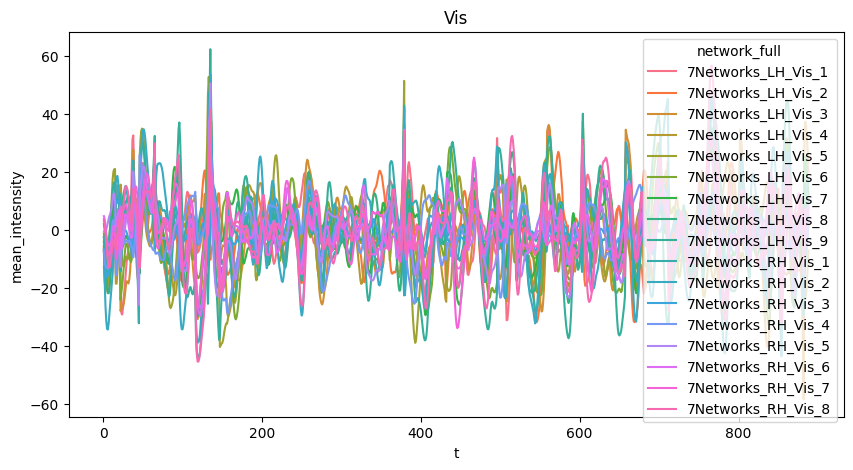

SomMot


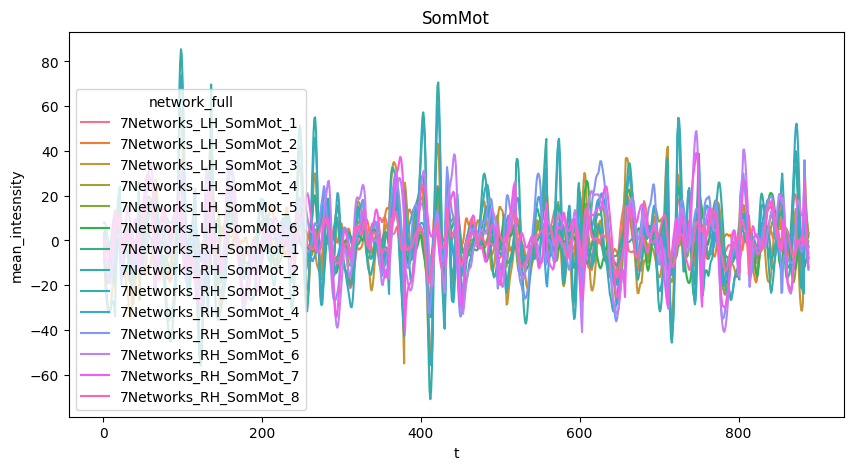

DorsAttn_Post


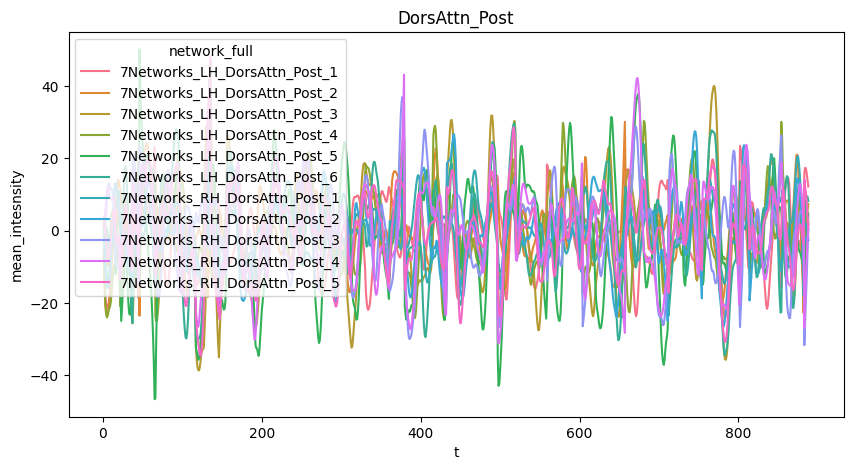

DorsAttn_FEF


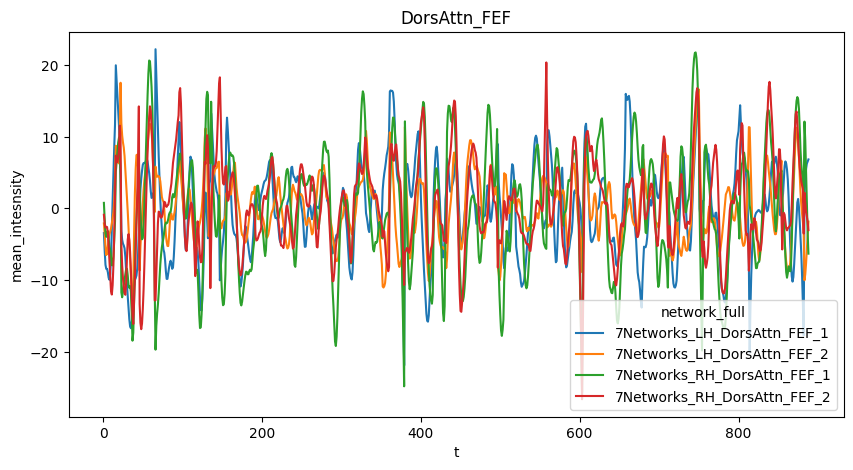

SalVentAttn_ParOper


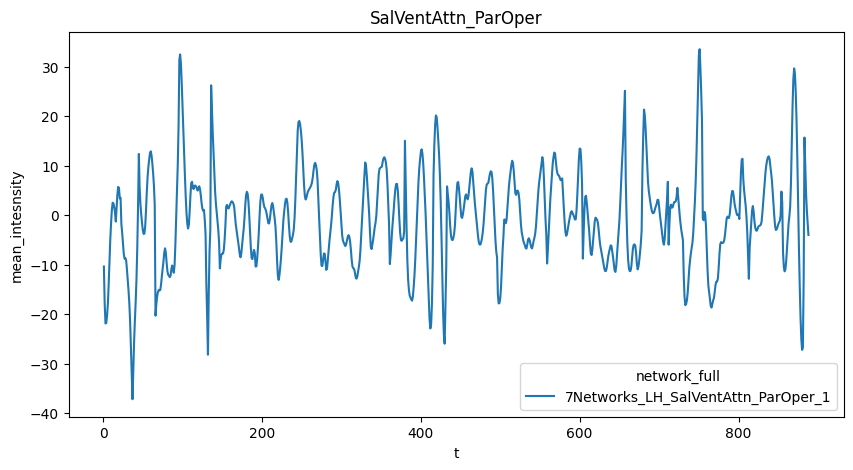

SalVentAttn_FrOper


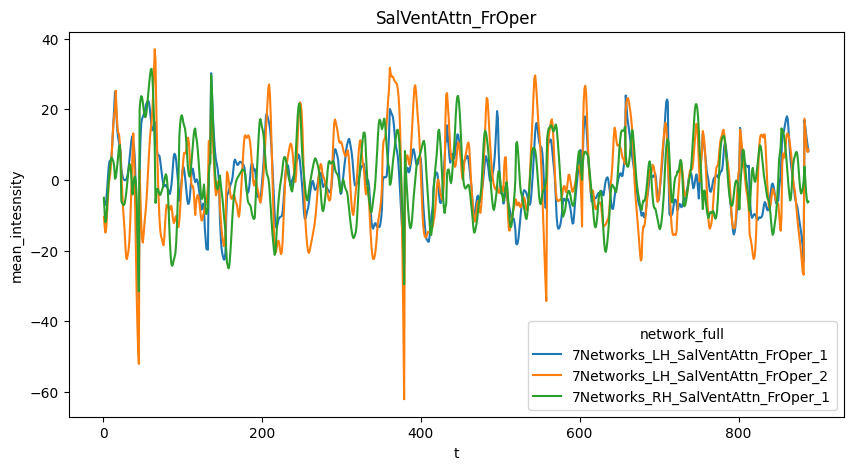

SalVentAttn_PFCl


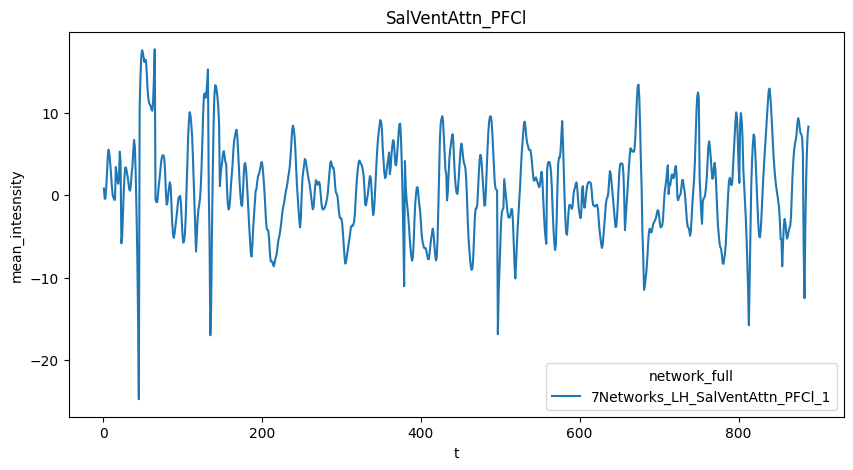

SalVentAttn_Med


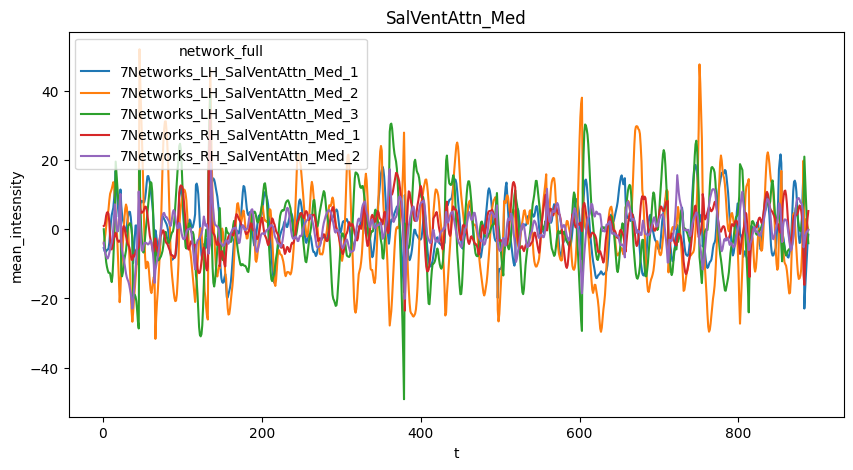

Limbic_OFC


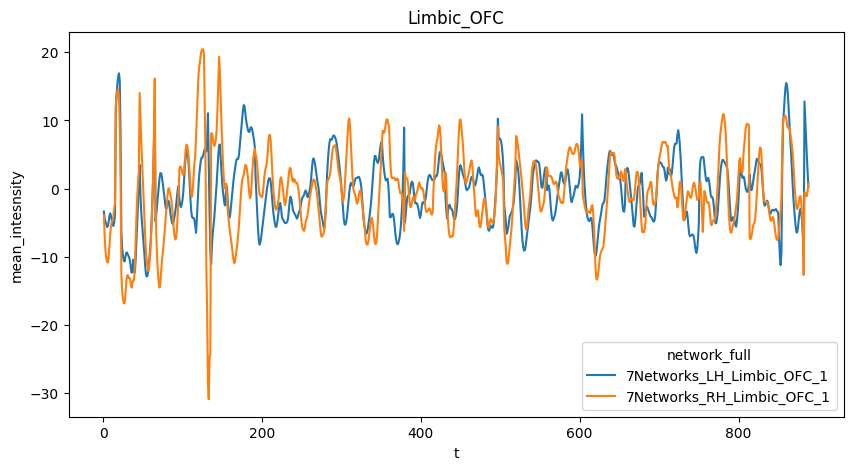

Limbic_TempPole


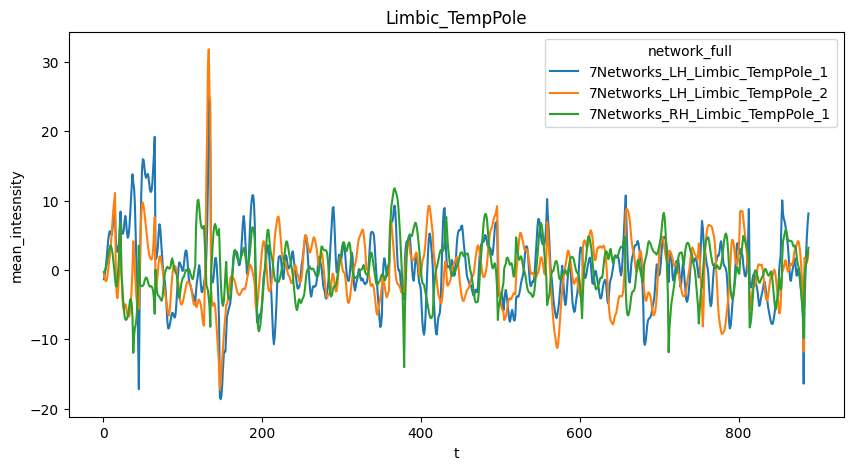

Cont_Par


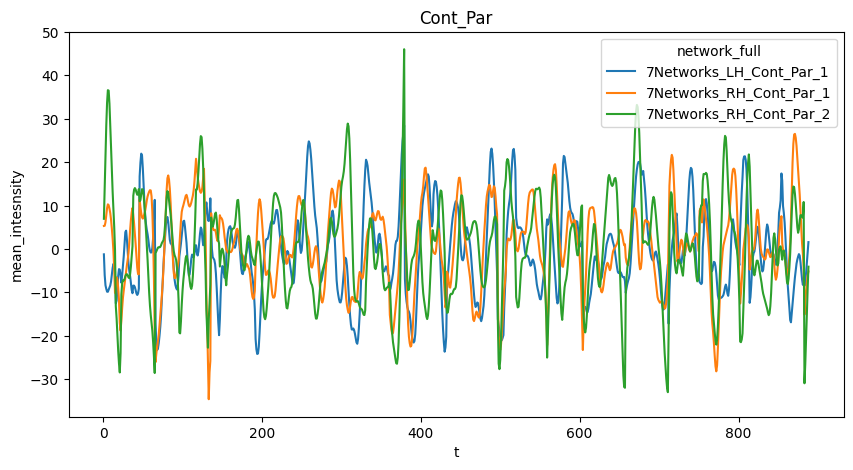

Cont_PFCl


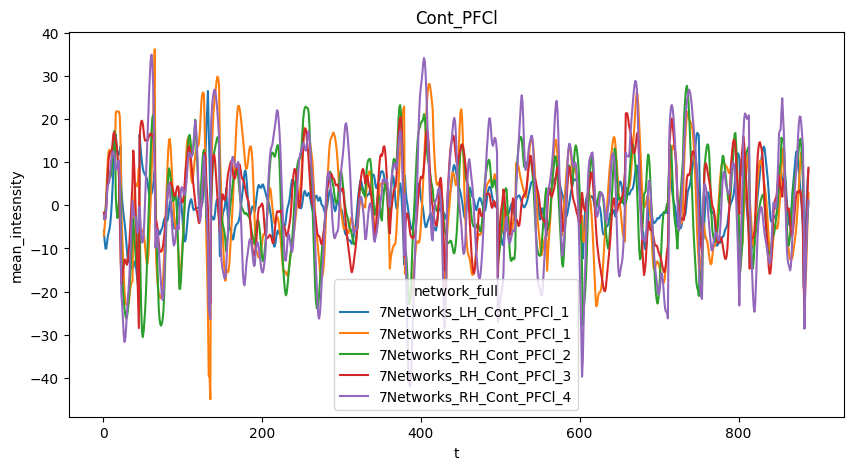

Cont_pCun


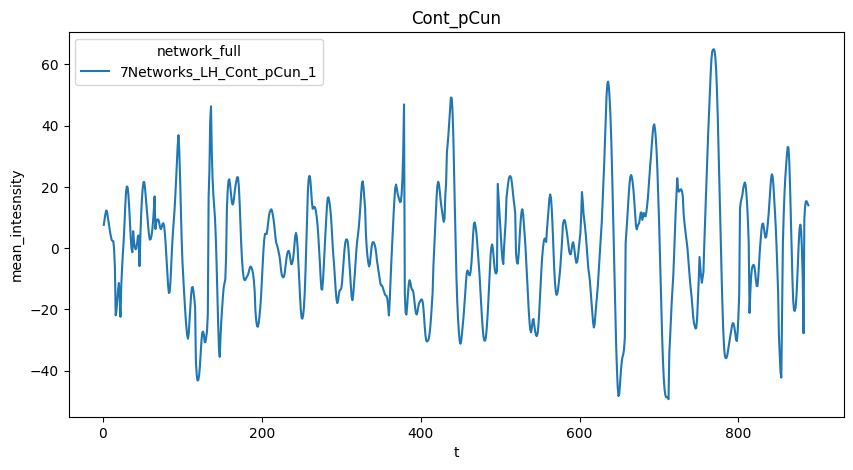

Cont_Cing


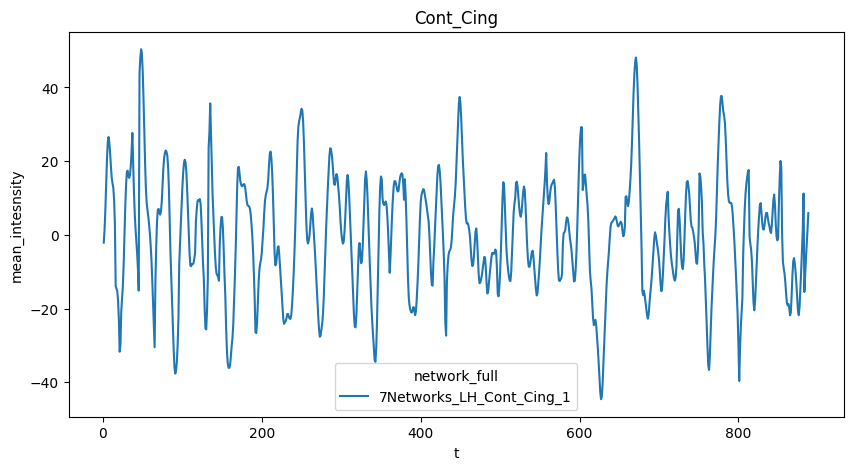

Default_Temp


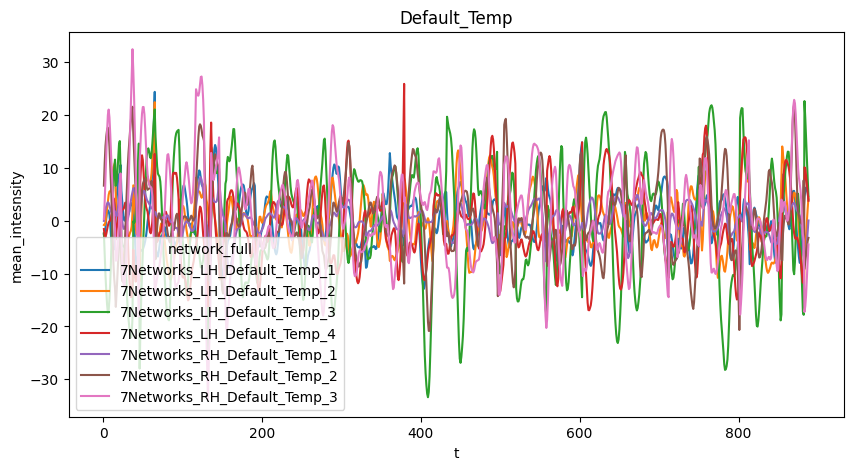

Default_PFC


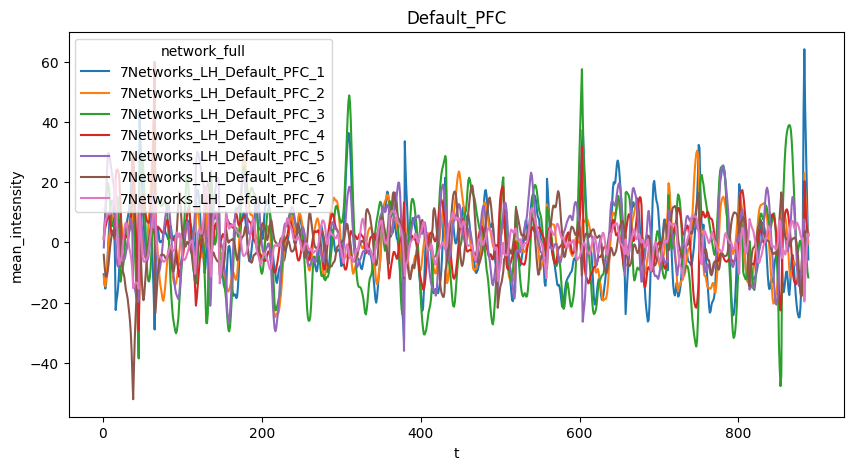

Default_PCC


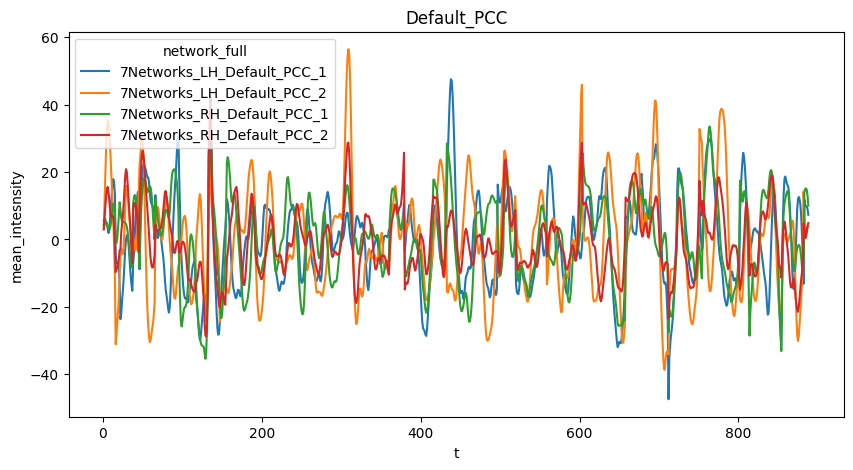

SalVentAttn_TempOccPar


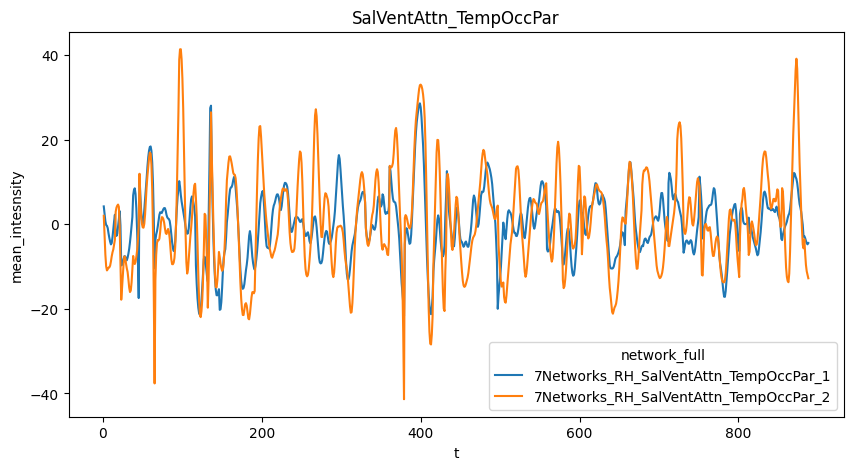

Cont_PFCmp


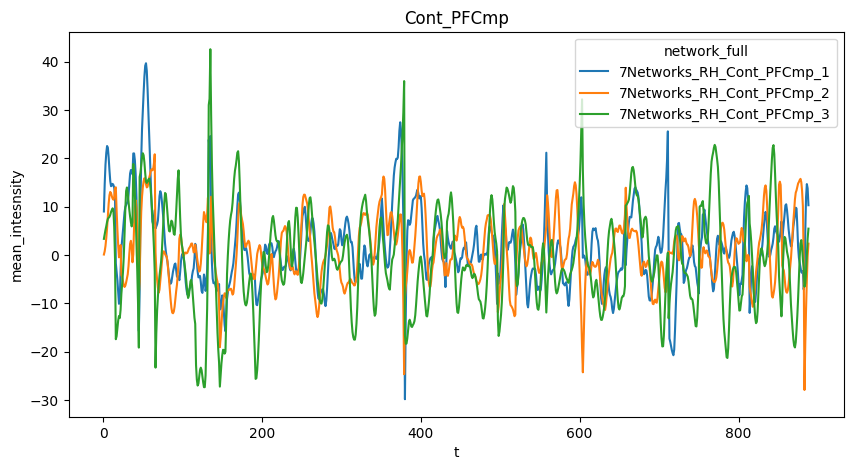

Default_Par


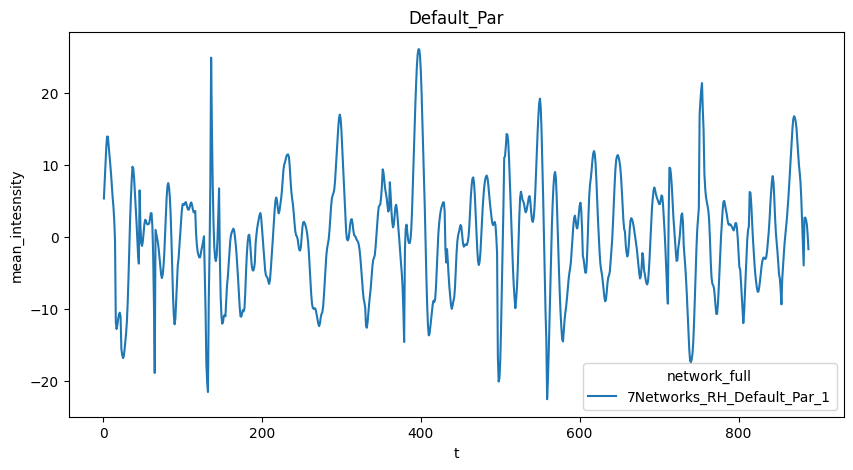

Default_PFCv


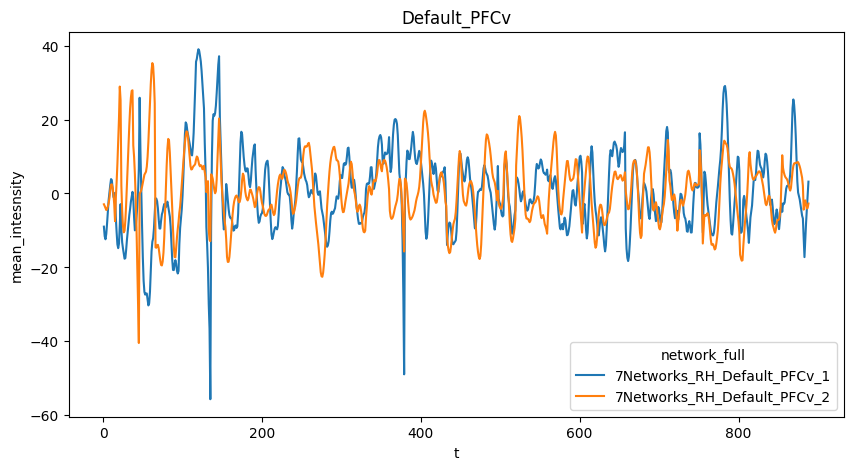

Default_PFCm


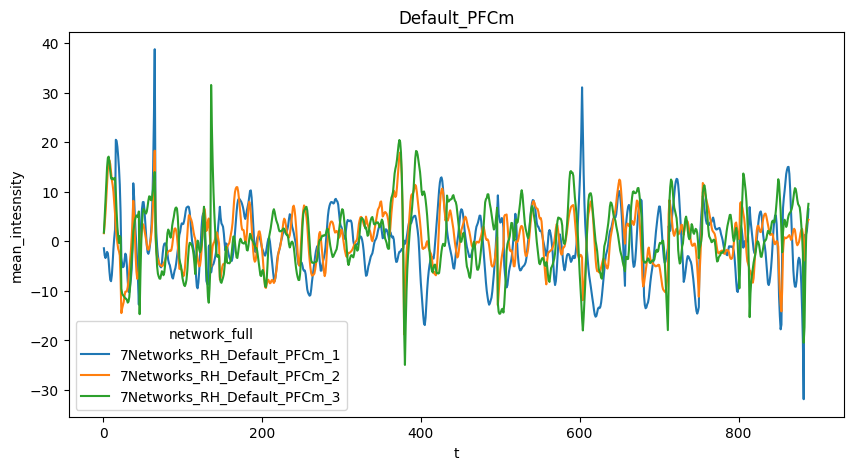

In [18]:
# # Plot the mean intensity timeseries for each network

# for network in mean_intensities.network.unique():
#     print(network)
#     # Plot the mean intensity timeseries for each network
#     plt.figure(figsize=(10, 5))

#     network_intensities = mean_intensities[mean_intensities.network == network]
#     network_intensities = network_intensities.explode('mean_intensity_timeseries')
#     network_intensities['mean_intesnsity'] = network_intensities.mean_intensity_timeseries.astype(float)
#     network_intensities['t'] = network_intensities.groupby('network_full').cumcount() + 1

#     sns.lineplot(data=network_intensities, x='t', y='mean_intesnsity', hue='network_full')
#     plt.title(network)
#     plt.show()


(100, 888)
(100, 100)


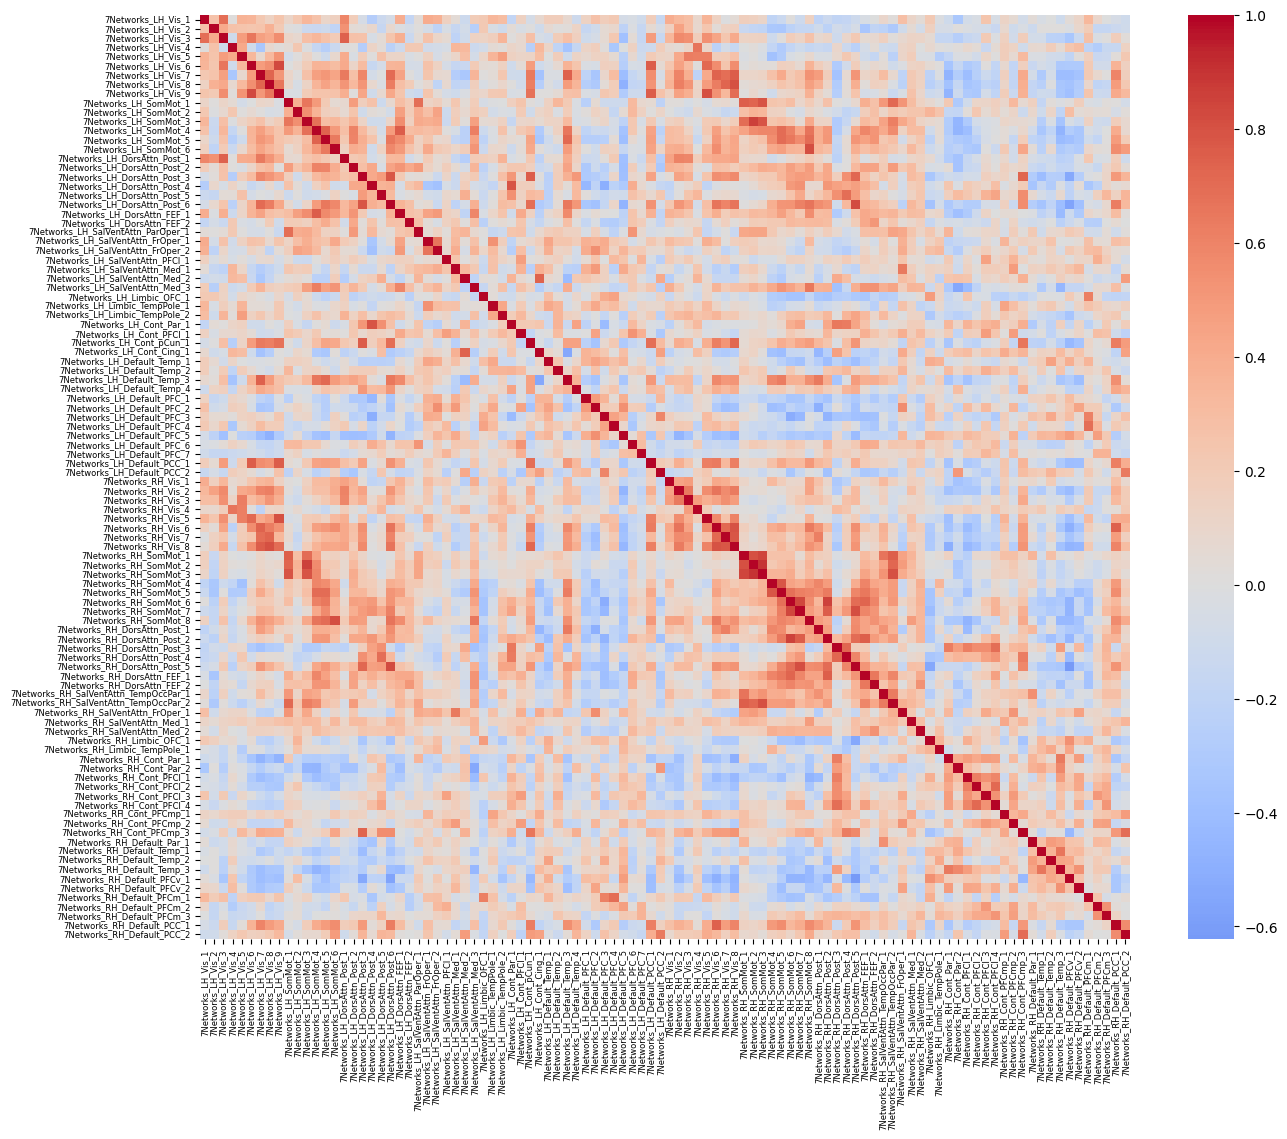

In [12]:
# # Plot correlation matrix of the mean intensity timeseries

# mean_intensities_arr = np.array(mean_intensities.mean_intensity_timeseries.tolist()).astype(float)
# print(mean_intensities_arr.shape)

# corr_matrix = np.corrcoef(mean_intensities_arr)
# print(corr_matrix.shape)
# # print(corr_matrix)


# plt.figure(figsize=(15, 12))
# sns.heatmap(corr_matrix, xticklabels=mean_intensities.network_full, yticklabels=mean_intensities.network_full, cmap='coolwarm', center=0)
# plt.xticks(fontsize=6)
# plt.yticks(fontsize=6)
# plt.show()


# Plotting the PCC and PFC

In [ ]:
from sklearn.preprocessing import MinMaxScaler 

labels_df = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['network_label', 'network_full', 'x', 'y', 'z', 't'])

In [79]:
# make ROI plot for the network

# networks = ['7Networks_RH_Default_PFCm_1','7Networks_RH_Default_PFCm_2','7Networks_RH_Default_PFCm_3']
# # networks = mean_intensities[mean_intensities.network_full.str.contains('PCC')].network_full
# idxs = network_labels.loc[network_labels.network_full.isin(networks), 'network_label']

# for idx in idxs:
#     # Create a mask for the network
#     mask = (ntwk_img_resampled.get_fdata() == idx).astype(float)
#     mask_img = nib.Nifti1Image(mask, fmri_img.affine) # Create mask image, now with the fMRI affine
#     plotting.plot_roi(mask_img, cmap='Paired')
#     plotting.show()

network_label                network_full  \
48             49  7Networks_LH_Default_PCC_1   
49             50  7Networks_LH_Default_PCC_2   
98             99  7Networks_RH_Default_PCC_1   
99            100  7Networks_RH_Default_PCC_2   

                            mean_intensity_timeseries side      network number  
48  [-5.61885365e-01, -2.42888209e+00, -3.18714574...   LH  Default_PCC      1  
49  [-9.34359556e+00, -1.92004914e+01, -2.99837894...   LH  Default_PCC      2  
98  [-5.02882094e+00, -6.17009809e+00, -6.17010891...   RH  Default_PCC      1  
99  [-6.80676985e+00, -1.00735866e+01, -1.43395995...   RH  Default_PCC      2

network_label                 network_full  \
95             96  7Networks_RH_Default_PFCm_1   
96             97  7Networks_RH_Default_PFCm_2   
97             98  7Networks_RH_Default_PFCm_3   

                            mean_intensity_timeseries side       network  \
95  [-2.57475414e+00, -2.76165494e-01, 1.55698335e...   RH  Default_PFCm   
96  [-2.42971311e+00, -3.00669888e+00, -4.37003473...   RH  Default_PFCm   
97  [6.47653155e+00, 1.25487225e+01, 1.67672376e+0...   RH  Default_PFCm   

   number  
95      1  
96      2  
97      3

0.030215975172609672


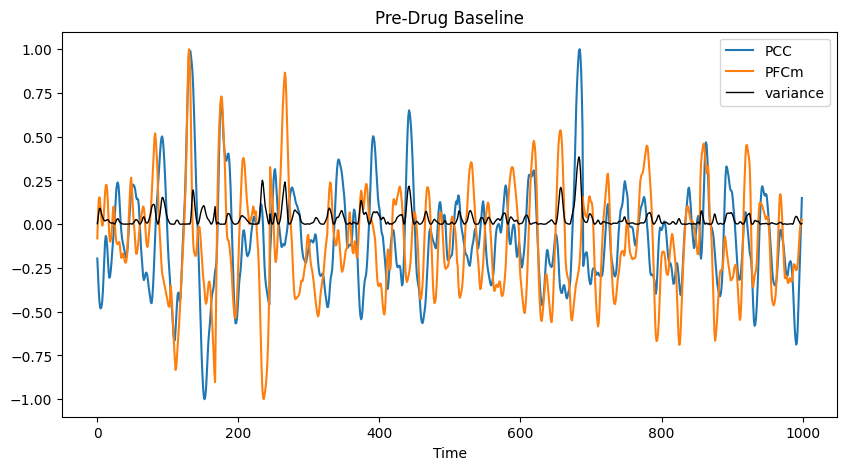

In [118]:
sample = 'sub-01_ses-V1_task-S0_run-01_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold' # pre-drug baseline
data = load_mean_intensity_timeseries(sample)
min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) 


pcc_networks = data[data.network_full.str.contains('Default_PCC')]
display(pcc_networks.head())
pcc_networks_arr = np.array(pcc_networks.mean_intensity_timeseries.tolist()).astype(float) # Convert pandas serise of lists to 2d numpy array
mean_pcc_intensity = pcc_networks_arr.mean(axis=0)
normalized_pcc_intesnity = min_max_scaler.fit_transform(mean_pcc_intensity.reshape(-1, 1),).reshape(-1)

pfcm_networks = data[data.network_full.str.contains('Default_PFCm')]
display(pfcm_networks.head())
pfcm_networks_arr = np.array(pfcm_networks.mean_intensity_timeseries.tolist()).astype(float) # Convert pandas serise of lists to 2d numpy array
mean_pfc_intensity = pfcm_networks_arr.mean(axis=0)
normalized_pfc_intesnity = min_max_scaler.fit_transform(mean_pfc_intensity.reshape(-1, 1)).reshape(-1)

variance = np.var(np.array([normalized_pcc_intesnity, normalized_pfc_intesnity]), axis=0)
print(variance.mean())

# make a lineplot that shows two lines, one with mean_pcc_intensity, and oen with mean_pfc_intensity
plt.figure(figsize=(10, 5))
sns.lineplot(data=normalized_pcc_intesnity, label='PCC')
sns.lineplot(data=normalized_pfc_intesnity, label='PFCm')
sns.lineplot(data=variance, label='variance', color='black', linewidth=1)
plt.xlabel('Time')
plt.title('Pre-Drug Baseline')
plt.show()


network_label                network_full  \
48             49  7Networks_LH_Default_PCC_1   
49             50  7Networks_LH_Default_PCC_2   
98             99  7Networks_RH_Default_PCC_1   
99            100  7Networks_RH_Default_PCC_2   

                            mean_intensity_timeseries side      network number  
48  [5.51696025e+00, 5.04204883e+00, 5.01215469e+0...   LH  Default_PCC      1  
49  [3.10521802e+00, 1.12909527e+01, 1.99188378e+0...   LH  Default_PCC      2  
98  [4.33260304e+00, 6.17903558e+00, 6.08704832e+0...   RH  Default_PCC      1  
99  [2.99864214e+00, 6.55556042e+00, 9.91283579e+0...   RH  Default_PCC      2

network_label                 network_full  \
95             96  7Networks_RH_Default_PFCm_1   
96             97  7Networks_RH_Default_PFCm_2   
97             98  7Networks_RH_Default_PFCm_3   

                            mean_intensity_timeseries side       network  \
95  [-1.39692416e+00, -2.85453154e+00, -3.36440306...   RH  Default_PFCm   
96  [1.64761171e+00, 3.50056358e+00, 5.70382902e+0...   RH  Default_PFCm   
97  [1.77183876e+00, 4.84309951e+00, 8.18609737e+0...   RH  Default_PFCm   

   number  
95      1  
96      2  
97      3

0.02539820920019809


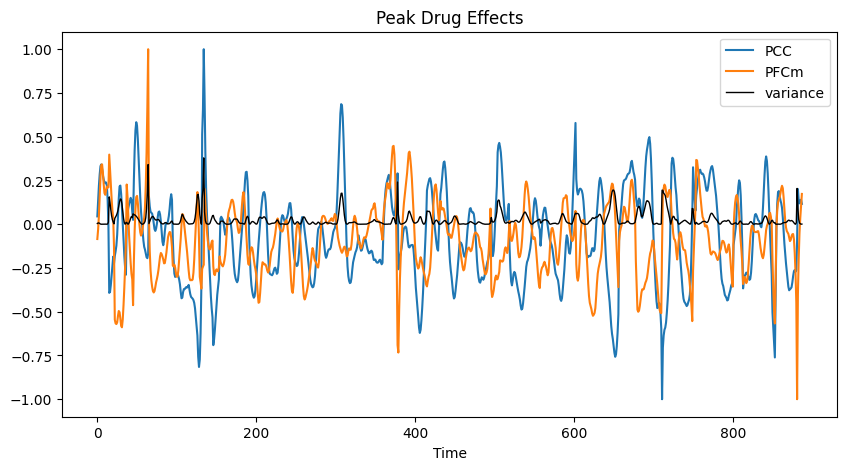

In [119]:
sample = 'sub-01_ses-V1_task-S2_run-02_space-MNI152NLin2009cAsym_res-2_desc-denoisedSmoothed_bold' # Peak drug effects
data = load_mean_intensity_timeseries(sample)
min_max_scaler = MinMaxScaler(feature_range=(-1, 1)) 


pcc_networks = data[data.network_full.str.contains('Default_PCC')]
display(pcc_networks.head())
pcc_networks_arr = np.array(pcc_networks.mean_intensity_timeseries.tolist()).astype(float) # Convert pandas serise of lists to 2d numpy array
mean_pcc_intensity = pcc_networks_arr.mean(axis=0)
normalized_pcc_intesnity = min_max_scaler.fit_transform(mean_pcc_intensity.reshape(-1, 1)).reshape(-1)

pfcm_networks = data[data.network_full.str.contains('Default_PFCm')]
display(pfcm_networks.head())
pfcm_networks_arr = np.array(pfcm_networks.mean_intensity_timeseries.tolist()).astype(float) # Convert pandas serise of lists to 2d numpy array
mean_pfc_intensity = pfcm_networks_arr.mean(axis=0)

normalized_pfc_intesnity = min_max_scaler.fit_transform(mean_pfc_intensity.reshape(-1, 1)).reshape(-1)

variance = np.var(np.array([normalized_pcc_intesnity, normalized_pfc_intesnity]), axis=0)
print(variance.mean())

# make a lineplot that shows two lines, one with mean_pcc_intensity, and oen with mean_pfc_intensity
plt.figure(figsize=(10, 5))
sns.lineplot(data=normalized_pcc_intesnity, label='PCC')
sns.lineplot(data=normalized_pfc_intesnity, label='PFCm')
sns.lineplot(data=variance, label='variance', color='black', linewidth=1)
plt.xlabel('Time')
plt.title('Peak Drug Effects')
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


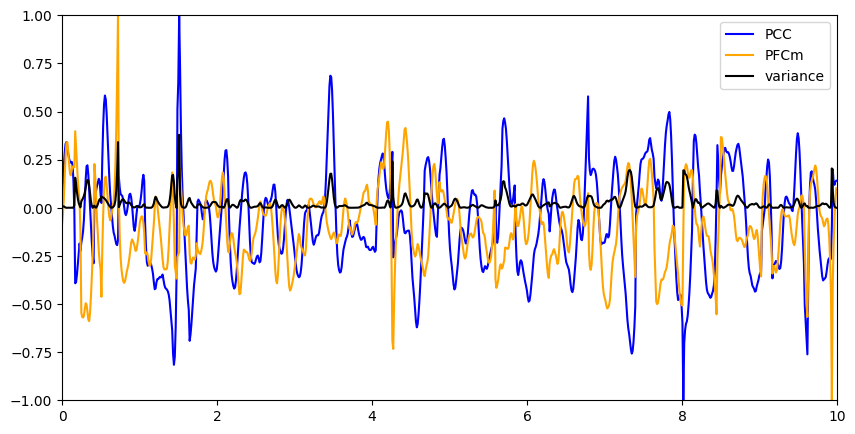

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Sample data
time = np.linspace(0, 10, 888)

fig, ax = plt.subplots(figsize=(10,5))
line1, = ax.plot(time, normalized_pcc_intesnity, color='b', label='PCC')
line2, = ax.plot(time, mean_pfc_intensity, color='orange', label='PFCm')
line3, = ax.plot(time, variance, color='k', label='variance')
ax.legend()

def update(num, time, PCC, PFCm, variance, line1, line2, line3):
    line1.set_data(time[:num], PCC[:num])
    line2.set_data(time[:num], PFCm[:num])
    line3.set_data(time[:num], variance[:num])
    line1.axes.axis([0, 10, -1, 1])
    return line1, line2, line3

ani = animation.FuncAnimation(fig, update, len(time), fargs=[time, normalized_pcc_intesnity, normalized_pfc_intesnity, variance, line1, line2, line3],
                              interval=25, blit=True)
ani.save(f'images_dynamic/{sample}_pcc_pfc.gif')
plt.show()

 7Networks_LH_Default_PCC_1
 7Networks_LH_Default_PCC_2
 7Networks_RH_Default_PCC_1
 7Networks_RH_Default_PCC_2
7Networks_RH_Default_PFCm_1
7Networks_RH_Default_PFCm_2
7Networks_RH_Default_PFCm_3


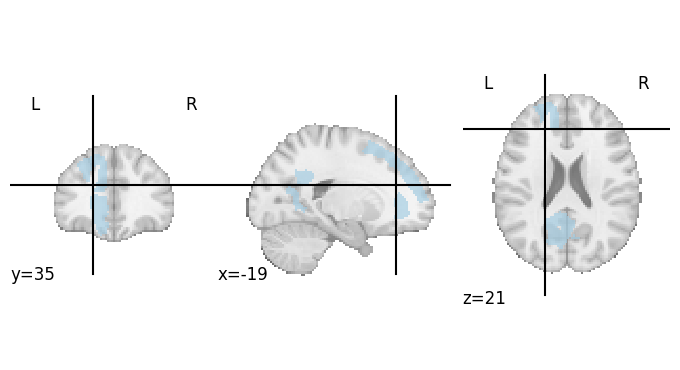

In [5]:
network_labels = pd.read_csv('data/Schaefer2018_100Parcels_7Networks_order.txt', sep='\t', names=['network_label', 'network_full', 'x', 'y', 'z', 't'])
roi_network_labels = network_labels[network_labels.network_full.str.contains('Default_PCC') | network_labels.network_full.str.contains('Default_PFCm')] 
idxs = roi_network_labels.network_label.unique()
print(roi_network_labels.network_full.sort_values().to_string(index=False))

# Create a mask for the network
roi_mask = np.isin(labels_img.get_fdata(), idxs).astype(float)
roi_img = nib.Nifti1Image(roi_mask, fmri_img.affine)
plotting.plot_roi(roi_img, cmap='Paired')
plotting.show()

# Apply the mask to the fMRI data
fmri_roi_run_series = masking.apply_mask(fmri_img, roi_img)

# Bring masked data back into 4D 
fmri_roi_img = masking.unmask(fmri_roi_run_series, roi_img)


count    9.608471e+08
mean     8.556647e-04
std      1.944513e+00
min     -2.227422e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.255469e+02
dtype: float64


<Axes: >

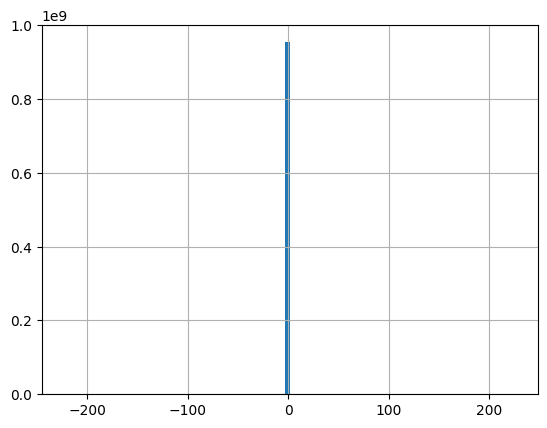

In [6]:
intensities = pd.Series(fmri_roi_img.get_fdata().reshape(-1))
print(intensities.describe())
intensities.hist(bins=100)

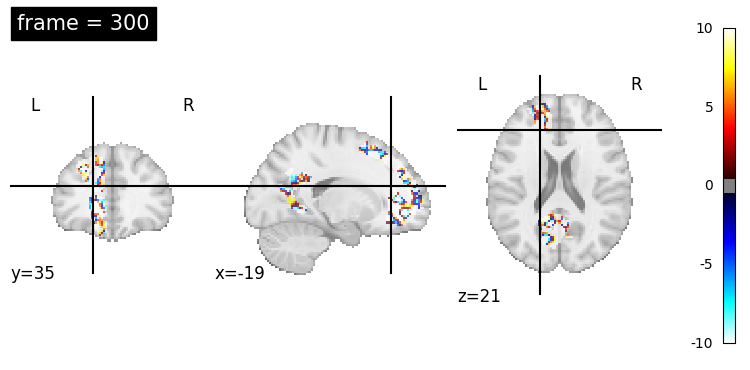

In [10]:
i = 300

volume = image.index_img(fmri_roi_img, i)
display = plotting.plot_roi(
    volume, title=f'frame = {i}', display_mode='ortho', cut_coords=(-19, 35, 21), 
    colorbar=True, cmap=nilearn_cmaps['cold_hot'], vmin=-10, vmax=10
)
plotting.show()